<a href="https://colab.research.google.com/github/INFINITY-RUBER/Curso_Deep_Learning_Con_TernsorFlow_Machine-Learning_e_IA-/blob/master/scripts/tema08/06-doc2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Doc2Vec

In [0]:
#!pip install tensorflow==1.14


In [87]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import pickle
import os
import nlp_helpers # libreria que creamos anteriormente

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [88]:
print(tf.__version__)
#from nltk.corpus import stopwords
import tensorflow as tf
tf.test.gpu_device_name()

1.14.0


''

In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [0]:
session = tf.Session()

In [0]:
texts, target = nlp_helpers.load_movies_data()

In [0]:
batch_size = 500
vocabulary_size = 7500
generations = 20000
model_learning_rate = 0.001
embedding_size = 200
doc_embedding_size = 100
concatenated_size = embedding_size + doc_embedding_size
num_sampled = int(batch_size/2)
window_size = 3

save_embedding_every = 1000
print_valid_every = 2000
print_loss_every = 500

stops = stopwords.words('english')
valid_words = ['love', 'hate', 'happy', 'sad', 'man', 'woman', 'movie']

In [0]:
texts = nlp_helpers.normalize_text(texts, stops)
target = [target[ix] for ix, x in enumerate(texts) if len(x.split())>window_size]
texts = [x for x in texts if len(x.split())>window_size]
assert(len(target)==len(texts))

In [95]:
word_dictionary = nlp_helpers.build_dictionary(texts, vocabulary_size)
word_dictionary_rev = dict(zip(word_dictionary.values(), word_dictionary.keys()))
text_data = nlp2_helpers.text_to_numbers(texts, word_dictionary)
valid_examples = [word_dictionary[x] for x in valid_words]
valid_examples

[28, 980, 791, 354, 131, 565, 2]

In [0]:
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
doc_embeddings = tf.Variable(tf.random_uniform([len(texts), doc_embedding_size], -1.0,1.0))
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, concatenated_size],
                                             stddev=1.0/np.sqrt(concatenated_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

In [0]:
x_inputs = tf.placeholder(tf.int32, shape=[None, window_size+1])
y_target = tf.placeholder(tf.int32, shape = [None, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [0]:
embed = tf.zeros([batch_size, embedding_size])
for element in range(window_size):
    embed += tf.nn.embedding_lookup(embeddings, x_inputs[:, element])
doc_idx = tf.slice(x_inputs, [0, window_size], [batch_size,1])
doc_embed = tf.nn.embedding_lookup(doc_embeddings, doc_idx)
final_embed = tf.concat([embed, tf.squeeze(doc_embed)], axis=1)

In [0]:
loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights, biases=nce_biases,
                                    labels = y_target, inputs = final_embed,
                                    num_sampled=num_sampled, num_classes = vocabulary_size))

In [0]:
optim = tf.train.GradientDescentOptimizer(learning_rate=model_learning_rate)
train_step = optim.minimize(loss)

In [0]:
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings),1, keepdims=True))
normalized_embeddings = embeddings/norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

In [0]:
saver = tf.train.Saver({"embeddings":embeddings, "doc_embeddings":doc_embeddings})
init = tf.global_variables_initializer()
session.run(init)

In [104]:
loss_vect = []
loss_x_vect = []
for i in range(generations):
    batch_inputs, batch_labels = nlp_helpers.generate_batch_data(text_data, batch_size, window_size, 'doc2vec')
    feed_dict = {x_inputs: batch_inputs, y_target: batch_labels}
    session.run(train_step, feed_dict=feed_dict)
    
    if(i+1) % print_loss_every == 0:
        loss_val = session.run(loss, feed_dict=feed_dict)
        loss_vect.append(loss_val)
        loss_x_vect.append(i+1)
        print("Pérdidas en el paso {}: {}".format(i+1, loss_val))
        
    if(i+1) % print_valid_every == 0:
        sim = session.run(similarity, feed_dict=feed_dict)
        for j in range(len(valid_words)):
            valid_word = word_dictionary_rev[valid_examples[j]]
            top_k = 5
            nearest = (-sim[j,:]).argsort()[1:top_k+1]
            log_str = "Palabras más cercanas a {}: ".format(valid_word)
            for k in range(top_k):
                close_word = word_dictionary_rev[nearest[k]]
                log_str = '{}\n -{}'.format(log_str, close_word)
            print(log_str)
    if (i+1) % save_embedding_every == 0:
        with open(os.path.join("../../datasets", 'doc2vec_movie_vocab.pkl'), 'wb') as f:
            pickle.dump(word_dictionary, f)
        model_checkpoint_path = os.path.join("../../datasets", 'doc2vec_movie_embeddings.ckpt')
        save_path = saver.save(session, model_checkpoint_path)
        print("Modelo guardado en: {}".format(save_path))

Pérdidas en el paso 500: 182.13194274902344
Pérdidas en el paso 1000: 57.32429504394531
Modelo guardado en: ../../datasets/doc2vec_movie_embeddings.ckpt
Pérdidas en el paso 1500: 32.22222900390625
Pérdidas en el paso 2000: 15.282027244567871
Palabras más cercanas a love: 
 -diaz
 -tropes
 -bottom
 -odds
 -washingtons
Palabras más cercanas a hate: 
 -dire
 -claim
 -visit
 -damned
 -darker
Palabras más cercanas a happy: 
 -palmas
 -remembered
 -success
 -importantly
 -variation
Palabras más cercanas a sad: 
 -folks
 -plot
 -discomfort
 -temptation
 -pause
Palabras más cercanas a man: 
 -theatre
 -turns
 -fortunately
 -shootemup
 -lurid
Palabras más cercanas a woman: 
 -cry
 -alist
 -tiny
 -r
 -laissezpasser
Palabras más cercanas a movie: 
 -standards
 -lectures
 -errol
 -leads
 -mild
Modelo guardado en: ../../datasets/doc2vec_movie_embeddings.ckpt
Pérdidas en el paso 2500: 12.671266555786133
Pérdidas en el paso 3000: 11.978609085083008
Modelo guardado en: ../../datasets/doc2vec_movie_emb

In [105]:
!ls ../../datasets

checkpoint
doc2vec_movie_embeddings.ckpt.data-00000-of-00001
doc2vec_movie_embeddings.ckpt.index
doc2vec_movie_embeddings.ckpt.meta
doc2vec_movie_vocab.pkl
movies_data


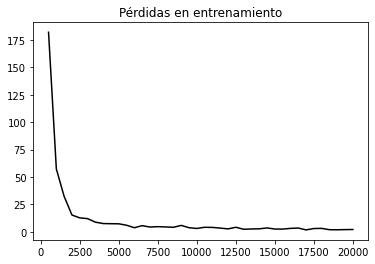

In [111]:
plt.plot(loss_x_vect, loss_vect, 'k-', label = "Función de pérdidas")
plt.title("Pérdidas en entrenamiento")
plt.show()

## Análisis de sentimiento con doc2vec

In [0]:
max_words = 20
logistic_batch_size = 500 

In [0]:
train_idx = np.sort(np.random.choice(len(target), round(0.8*len(target)), replace = False))
test_idx = np.sort(np.array(list(set(range(len(target)))-set(train_idx))))

In [0]:
texts_train = [x for ix, x in enumerate(texts) if ix in train_idx]
texts_test = [x for ix, x in enumerate(texts) if ix in test_idx]
target_train = np.array([x for ix, x in enumerate(target) if ix in train_idx])
target_test = np.array([x for ix, x in enumerate(target) if ix in test_idx])

In [0]:
text_data_train = np.array(nlp_helpers.text_to_numbers(texts_train, word_dictionary))
text_data_test = np.array(nlp_helpers.text_to_numbers(texts_test, word_dictionary))

text_data_train = np.array([x[0:max_words] for x in [y + [0]*max_words for y in text_data_train]])
text_data_test = np.array([x[0:max_words] for x in [y + [0]*max_words for y in text_data_test]])

In [0]:
log_x_inputs = tf.placeholder(tf.int32, shape=[None, max_words+1])
log_y_target = tf.placeholder(tf.int32, shape=[None,1])

In [0]:
log_embed = tf.zeros([logistic_batch_size, embedding_size])
for element in range(max_words):
    log_embed += tf.nn.embedding_lookup(embeddings, log_x_inputs[:, element])
log_doc_idx = tf.slice(log_x_inputs, [0, max_words], [logistic_batch_size, 1])
log_doc_embed = tf.nn.embedding_lookup(doc_embeddings, log_doc_idx)
log_final_embed = tf.concat([log_embed, tf.squeeze(log_doc_embed)], axis = 1)

In [0]:
A = tf.Variable(tf.random_normal(shape=[concatenated_size, 1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))
model_output = tf.add(tf.matmul(log_final_embed, A), b)
logistic_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, 
                                                                       labels=tf.cast(log_y_target, tf.float32)))

In [0]:
prediction = tf.round(tf.sigmoid(model_output))
predictions_correct = tf.cast(tf.equal(prediction, tf.cast(log_y_target, tf.float32)), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

In [0]:
# optimizador
logistic_opt = tf.train.GradientDescentOptimizer(learning_rate=0.01)
logistic_train_step = logistic_opt.minimize(logistic_loss, var_list=[A,b])

In [0]:
init = tf.global_variables_initializer()
session.run(init)

In [124]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []
i_data = []

for i in range(10000):
    rand_idx = np.random.choice(text_data_train.shape[0], size = logistic_batch_size)
    rand_x = text_data_train[rand_idx]
    rand_x_doc_idx = train_idx[rand_idx]
    rand_x = np.hstack((rand_x, np.transpose([rand_x_doc_idx])))# unir horizontalmente
    rand_y = np.transpose([target_train[rand_idx]])
    
    feed_dict={log_x_inputs: rand_x, log_y_target: rand_y}
    session.run(logistic_train_step, feed_dict=feed_dict)
    
    if(i+1)%100==0:
        
        rand_idx_test = np.random.choice(text_data_test.shape[0], size = logistic_batch_size)
        rand_x_test = text_data_test[rand_idx_test]
        rand_x_doc_idx_test = test_idx[rand_idx_test]
        rand_x_test = np.hstack((rand_x_test, np.transpose([rand_x_doc_idx_test])))
        rand_y_test = np.transpose([target_test[rand_idx_test]])

        feed_dict_test={log_x_inputs: rand_x_test, log_y_target: rand_y_test}
    
        
        i_data.append(i+1)
        
        train_loss_temp = session.run(logistic_loss, feed_dict=feed_dict)
        train_loss.append(train_loss_temp)
        
        test_loss_temp = session.run(logistic_loss, feed_dict=feed_dict_test)
        test_loss.append(test_loss_temp)
        
        train_acc_temp = session.run(accuracy, feed_dict=feed_dict)
        train_acc.append(train_acc_temp)
        
        test_acc_temp = session.run(accuracy, feed_dict=feed_dict_test)
        test_acc.append(test_acc_temp)
        
    if(i+1)%500==0:
        acc_and_loss = [i+1, train_loss_temp, test_loss_temp, train_acc_temp, test_acc_temp]
        acc_and_loss = [np.round(x,3) for x in acc_and_loss]
        print("Paso #{}, Train Loss {}, Test Loss {}. Train Acc {}, Test Acc{}".format(*acc_and_loss))

Paso #500, Train Loss 11.130000114440918, Test Loss 9.574999809265137. Train Acc 0.5120000243186951, Test Acc0.5640000104904175
Paso #1000, Train Loss 11.029999732971191, Test Loss 10.189000129699707. Train Acc 0.48399999737739563, Test Acc0.5299999713897705
Paso #1500, Train Loss 10.097000122070312, Test Loss 9.553999900817871. Train Acc 0.4819999933242798, Test Acc0.5120000243186951
Paso #2000, Train Loss 10.109999656677246, Test Loss 9.482999801635742. Train Acc 0.5059999823570251, Test Acc0.5419999957084656
Paso #2500, Train Loss 7.86899995803833, Test Loss 8.666999816894531. Train Acc 0.49399998784065247, Test Acc0.492000013589859
Paso #3000, Train Loss 6.4029998779296875, Test Loss 6.031000137329102. Train Acc 0.4880000054836273, Test Acc0.5180000066757202
Paso #3500, Train Loss 10.6850004196167, Test Loss 10.727999687194824. Train Acc 0.5080000162124634, Test Acc0.5120000243186951
Paso #4000, Train Loss 9.607999801635742, Test Loss 10.020000457763672. Train Acc 0.515999972820282

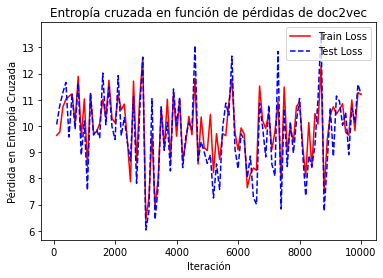

In [126]:
plt.plot(i_data, train_loss, 'r-', label="Train Loss")
plt.plot(i_data, test_loss, 'b--', label="Test Loss")
plt.title("Entropía cruzada en función de pérdidas de doc2vec")
plt.xlabel("Iteración")
plt.ylabel("Pérdida en Entropía Cruzada")
plt.legend(loc = "upper right")
plt.show()

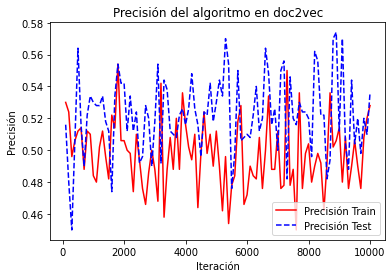

In [127]:
plt.plot(i_data, train_acc, 'r-', label="Precisión Train")
plt.plot(i_data, test_acc, 'b--', label="Precisión Test")
plt.title("Precisión del algoritmo en doc2vec")
plt.xlabel("Iteración")
plt.ylabel("Precisión")
plt.legend(loc = "lower right")
plt.show()